In [1]:
# https://www.kaggle.com/code/karnikakapoor/traffic-prediction-gru/notebook

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import SGD
from keras.layers import GRU, Dropout, Dense, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv("./csv_file/Q1_train.csv")
# test_data = pd.read_csv("./data/Q1_test.csv")

data = data[['datetime', 'ru_id', 'uenomax']]
# test = test_data[['datetime', 'ru_id']]

In [6]:
label_encoder = LabelEncoder()

data['ru_id'] = label_encoder.fit_transform(data['ru_id'])
# test['ru_id'] = label_encoder.fit_transform(test['ru_id'])

In [7]:
data["datetime"]= pd.to_datetime(data["datetime"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137445 entries, 0 to 137444
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  137445 non-null  datetime64[ns]
 1   ru_id     137445 non-null  int32         
 2   uenomax   137445 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 2.6 MB


In [8]:
df=data.copy() 
#Let's plot the Timeseries
# colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
# plt.figure(figsize=(20,4),facecolor="#627D78")
# Time_series=sns.lineplot(x=df['datetime'],y="uenomax",data=df, hue="ru_id", palette=colors)
# Time_series.set_title("ru_id")
# Time_series.set_ylabel("Number of uenomax")
# Time_series.set_xlabel("datetime")

In [9]:
df["Year"]= df['datetime'].dt.year
df["Month"]= df['datetime'].dt.month
df["Date_no"]= df['datetime'].dt.day
df["Hour"]= df['datetime'].dt.hour
df["Day"]= df.datetime.dt.strftime("%A")
df.head()

,datetime,ru_id,uenomax,Year,Month,Date_no,Hour,Day
0,2023-05-19,5,1,2023,5,19,0,Friday
1,2023-05-19,3,5,2023,5,19,0,Friday
2,2023-05-19,4,6,2023,5,19,0,Friday
3,2023-05-19,7,1,2023,5,19,0,Friday
4,2023-05-19,2,4,2023,5,19,0,Friday


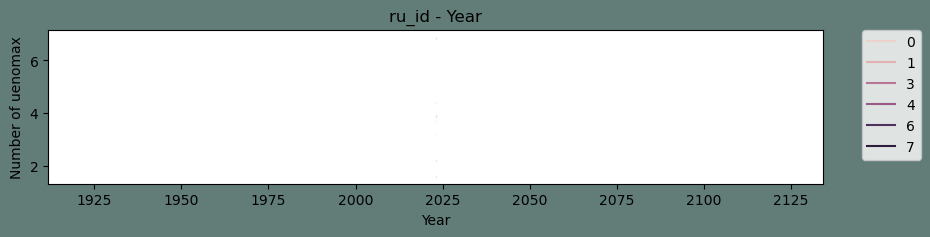

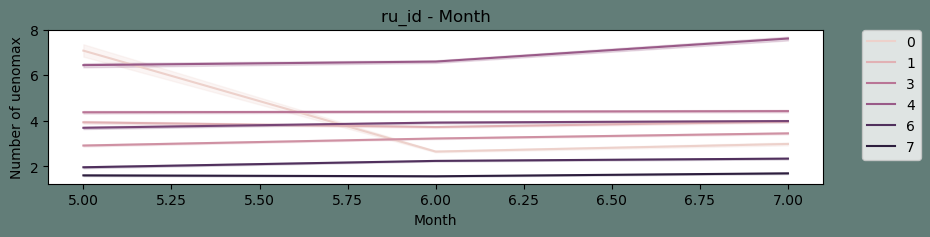

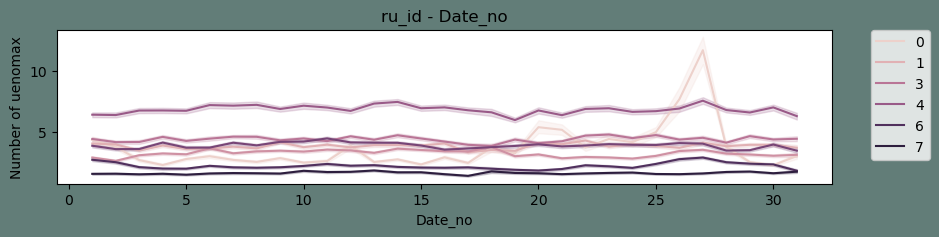

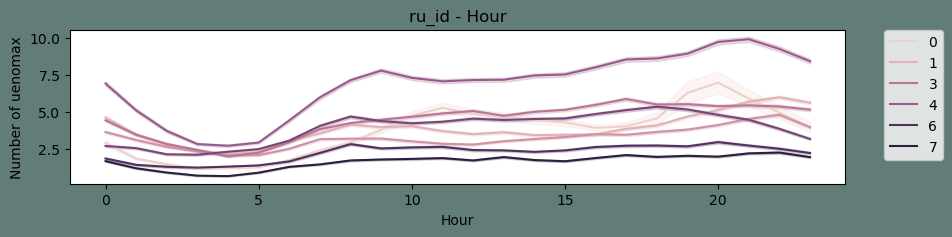

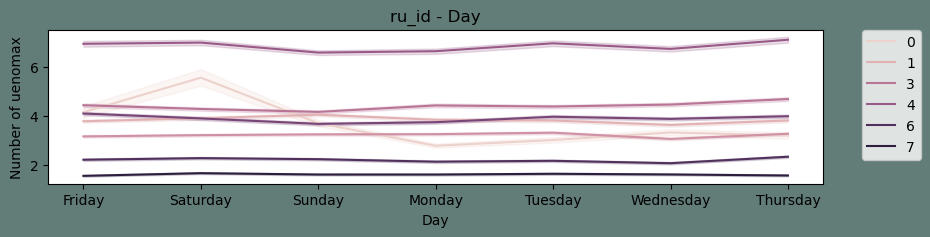

In [10]:

# Assuming you have already loaded your data into the 'df' DataFrame

new_features = ["Year", "Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10, 2), facecolor="#627D78")
    
    ax = sns.lineplot(x=df[i], y="uenomax", data=df, hue="ru_id")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f"ru_id - {i}")
    plt.ylabel("Number of uenomax")
    plt.xlabel(i)

plt.show()


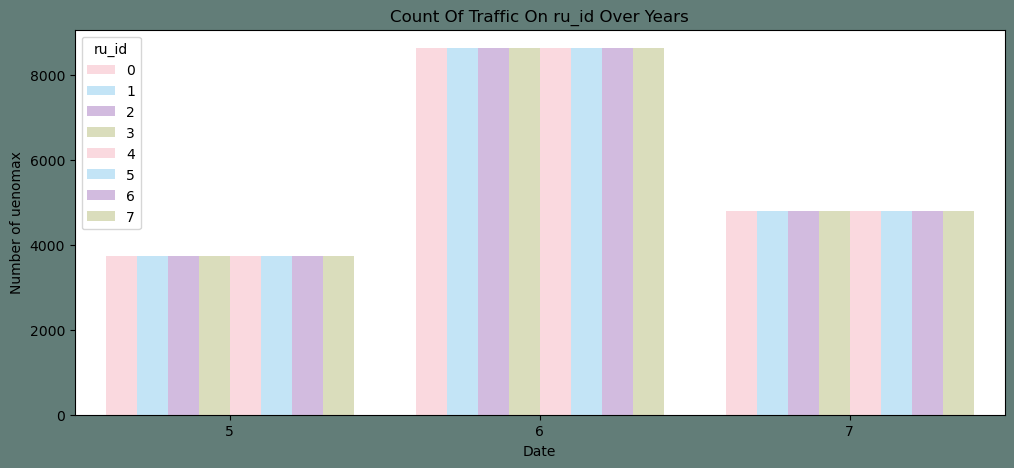

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded your data into the 'df' DataFrame

# Define a custom color palette
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]

plt.figure(figsize=(12, 5), facecolor="#627D78")
count = sns.countplot(data=df, x=df["Month"], hue="ru_id", palette=colors)
count.set_title("Count Of Traffic On ru_id Over Years")
count.set_ylabel("Number of uenomax")
count.set_xlabel("Date")

plt.show()


<AxesSubplot:>

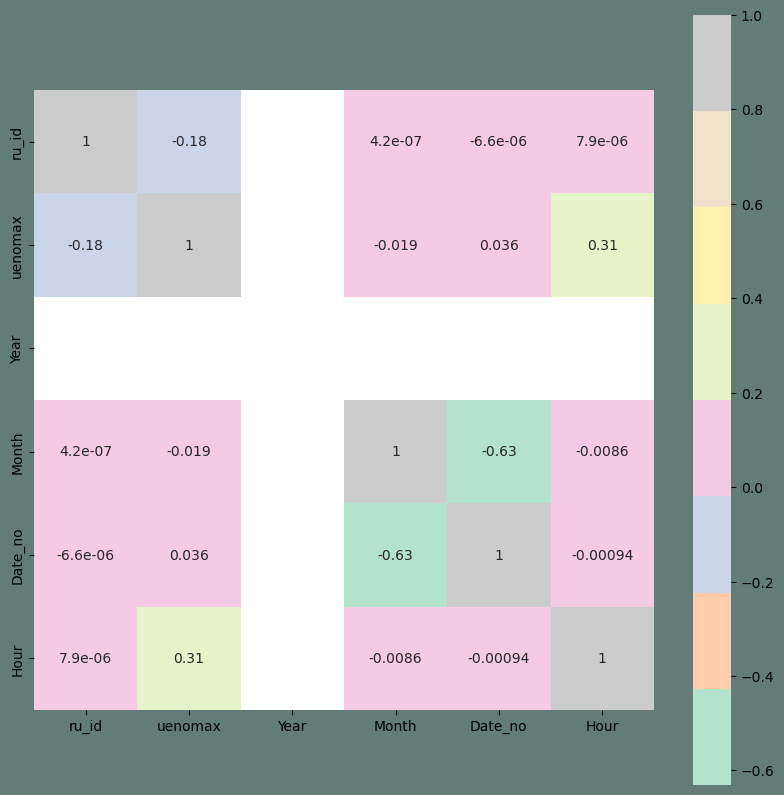

In [13]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

In [14]:
df_J = data.pivot(columns="ru_id", index="datetime")
df_J.describe()

uenomax                                                          \
ru_id             0             1             2             3             4   
count  17181.000000  17181.000000  17181.000000  17180.000000  17180.000000   
mean       3.711542      3.842209      3.222164      4.405471      6.855006   
std        4.781199      1.710667      1.378806      1.840004      2.880832   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      3.000000      2.000000      3.000000      5.000000   
50%        3.000000      4.000000      3.000000      4.000000      7.000000   
75%        4.000000      5.000000      4.000000      6.000000      9.000000   
max       74.000000     12.000000     10.000000     13.000000     20.000000   

                                                 
ru_id             5             6             7  
count  17180.000000  17181.000000  17181.000000  
mean       3.894529      2.208952      1.610966  
std        1.670006      1.229958      0.958987  
min        0.000000      0.000000      0.000000  
25%        3.000000      1.000000      1.000000  
50%        4.000000      2.000000      2.000000  
75%        5.000000      3.000000      2.000000  
max       12.000000     10.000000      6.000000

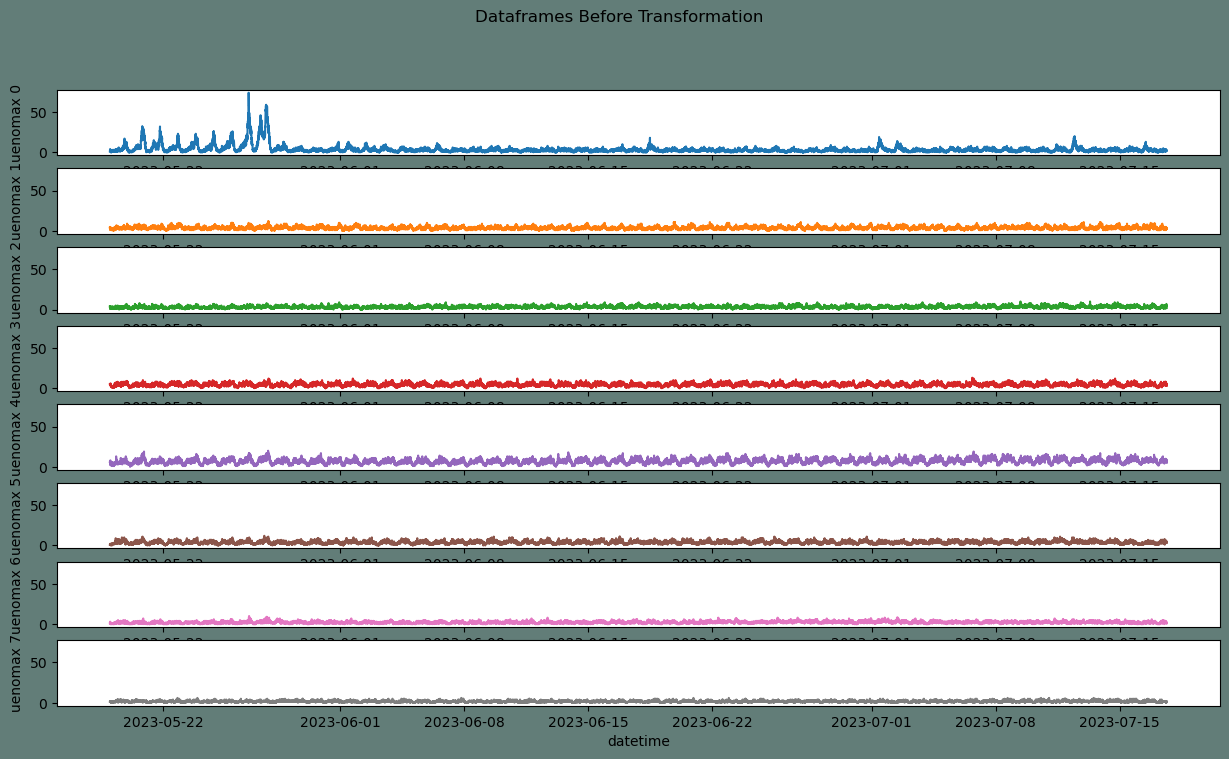

In [15]:
df_1 = df_J[[('uenomax', 0)]]
df_2 = df_J[[('uenomax', 1)]]
df_3 = df_J[[('uenomax', 2)]]
df_4 = df_J[[('uenomax', 3)]]
df_5= df_J[[('uenomax', 4)]]
df_6= df_J[[('uenomax', 5)]]
df_7= df_J[[('uenomax', 6)]]
df_8= df_J[[('uenomax', 7)]]


list_dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

colors = sns.color_palette("tab10")
#Function to plot comparitive plots of dataframes
def Sub_Plots8(df_1, df_2,df_3,df_4, df_5, df_6, df_7, df_8,title):
    fig, axes = plt.subplots(8, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="uenomax 0")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="uenomax 1")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="uenomax 2")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="uenomax 3")
    pl_4=sns.lineplot(ax=axes[4],data=df_5,color=colors[4])
    axes[4].set(ylabel ="uenomax 4")
    pl_4=sns.lineplot(ax=axes[5],data=df_6,color=colors[5])
    axes[5].set(ylabel ="uenomax 5")
    pl_4=sns.lineplot(ax=axes[6],data=df_7,color=colors[6])
    axes[6].set(ylabel ="uenomax 6")
    pl_4=sns.lineplot(ax=axes[7],data=df_8,color=colors[7])
    axes[7].set(ylabel ="uenomax 7")
    
    
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots8(df_1.uenomax, df_2.uenomax,df_3.uenomax,df_4.uenomax,
           df_5.uenomax, df_6.uenomax,df_7.uenomax,df_8.uenomax,
           "Dataframes Before Transformation")

# 여기서 치환을 해서 계절성 주기를 없애줘야함

In [16]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [df_1['uenomax'], df_2['uenomax'], df_3['uenomax'], df_4['uenomax'], 
              df_5['uenomax'], df_6['uenomax'], df_7['uenomax'], df_8['uenomax']] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -11.170197426593916
p-value: 2.6522635980572478e-20
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.30914450868178
p-value: 5.56816946421181e-30
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -16.42873797881632
p-value: 2.4901846510104176e-29
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -14.126557753706685
p-value: 2.373891354119475e-26
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -15.920916535427018
p-value: 7.925714895227683e-29
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -12.747724083671164
p-value: 8.667360344868758e-24
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -14.406991671182444
p-value: 8.325622031052865

In [17]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [18]:
df_N1, av_J1, std_J1 = Normalize(df_1, "uenomax")
Diff_1 = Difference(df_N1, col="uenomax", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "uenomax")
Diff_2 = Difference(df_N2, col="uenomax", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "uenomax")
Diff_3 = Difference(df_N3, col="uenomax", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "uenomax")
Diff_4 = Difference(df_N4, col="uenomax", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

df_N5, av_J5, std_J5 = Normalize(df_5, "uenomax")
Diff_5 = Difference(df_N5, col="uenomax", interval=1) #taking an hour's diffrence
df_N5 = df_N5[1:]
df_N5.columns = ["Norm"]
df_N5["Diff"]= Diff_5

df_N6, av_J6, std_J6 = Normalize(df_6, "uenomax")
Diff_6 = Difference(df_N6, col="uenomax", interval=1) #taking an hour's diffrence
df_N6 = df_N6[1:]
df_N6.columns = ["Norm"]
df_N6["Diff"]= Diff_6

df_N7, av_J7, std_J7 = Normalize(df_7, "uenomax")
Diff_7 = Difference(df_N7, col="uenomax", interval=1) #taking an hour's diffrence
df_N7 = df_N7[1:]
df_N7.columns = ["Norm"]
df_N7["Diff"]= Diff_7

df_N8, av_J8, std_J8 = Normalize(df_8, "uenomax")
Diff_8 = Difference(df_N8, col="uenomax", interval=1) #taking an hour's diffrence
df_N8 = df_N8[1:]
df_N8.columns = ["Norm"]
df_N8["Diff"]= Diff_8

In [19]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"],
             df_N5["Diff"], df_N6["Diff"], df_N7["Diff"], df_N8["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -13.38519102286602
p-value: 4.888870948141194e-25
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.971007265725813
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -30.631751786799178
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -38.457605726702496
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -32.275882543522265
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -35.894917362290215
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -29.5412222117305
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -26.4066

In [20]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

df_J5 = df_N5["Diff"].dropna()
df_J5 = df_J5.to_frame()

df_J6 = df_N6["Diff"].dropna()
df_J6 = df_J6.to_frame()

df_J7 = df_N7["Diff"].dropna()
df_J7 = df_J7.to_frame()

df_J8 = df_N8["Diff"].dropna()
df_J8 = df_J8.to_frame()

In [21]:
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

In [22]:
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)
J5_train, J5_test = Split_data(df_J5)
J6_train, J6_test = Split_data(df_J6)
J7_train, J7_test = Split_data(df_J7)
J8_train, J8_test = Split_data(df_J8)

In [23]:
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [24]:
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

X_trainJ5, y_trainJ5 = TnF(J5_train)
X_testJ5, y_testJ5 = TnF(J5_test)
X_trainJ5, X_testJ5 = FeatureFixShape(X_trainJ5, X_testJ5)

X_trainJ6, y_trainJ6 = TnF(J6_train)
X_testJ6, y_testJ6 = TnF(J6_test)
X_trainJ6, X_testJ6 = FeatureFixShape(X_trainJ6, X_testJ6)

X_trainJ7, y_trainJ7 = TnF(J7_train)
X_testJ7, y_testJ7 = TnF(J7_test)
X_trainJ7, X_testJ7 = FeatureFixShape(X_trainJ7, X_testJ7)

X_trainJ8, y_trainJ8 = TnF(J8_train)
X_testJ8, y_testJ8 = TnF(J8_test)
X_trainJ8, X_testJ8 = FeatureFixShape(X_trainJ8, X_testJ8)

In [ ]:
# #Model for the prediction
# def GRU_model(X_Train, y_Train, X_Test):
#     early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
#     #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
#     #The GRU model 
#     model = Sequential()
#     model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=1))
#     #Compiling the model
#     model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),loss='mean_squared_error')
#     model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
#     pred_GRU= model.predict(X_Test)
#     return pred_GRU

# #To calculate the root mean squred error in predictions
# def RMSE_Value(test,predicted):
#     rmse = math.sqrt(mean_squared_error(test, predicted))
#     print("The root mean squared error is {}.".format(rmse))
#     return rmse

# def MAE_Value(test, predicted):
#     mae = mean_absolute_error(test, predicted)
#     print("The mean absolute error is {}.".format(mae))
#     return mae

# #To plot the comparitive plot of targets and predictions
# def PredictionsPlot(test,predicted,m):
#     plt.figure(figsize=(12,5),facecolor="#627D78")
#     plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
#     plt.plot(predicted, color="#627D78",label="Predicted Values")
#     plt.title("GRU Traffic Prediction Vs True values")
#     plt.xlabel("DateTime")
#     plt.ylabel("Number of Vehicles")
#     plt.legend()
#     plt.show()

In [25]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {}.".format(mae))
    return mae

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

Epoch 1/50
102/102 [==============================] - 49s 337ms/step - loss: 0.6686
Epoch 2/50
102/102 [==============================] - 19s 186ms/step - loss: 0.4774
Epoch 3/50
102/102 [==============================] - 18s 172ms/step - loss: 0.4351
Epoch 4/50
102/102 [==============================] - 17s 171ms/step - loss: 0.3890
Epoch 5/50
102/102 [==============================] - 18s 173ms/step - loss: 0.3564
Epoch 6/50
102/102 [==============================] - 18s 178ms/step - loss: 0.3511
Epoch 7/50
102/102 [==============================] - 18s 181ms/step - loss: 0.3296
Epoch 8/50
102/102 [==============================] - 18s 180ms/step - loss: 0.3513
Epoch 9/50
102/102 [==============================] - 19s 182ms/step - loss: 0.3245
Epoch 10/50
102/102 [==============================] - 19s 188ms/step - loss: 0.3070
Epoch 11/50
102/102 [==============================] - 19s 183ms/step - loss: 0.3045
Epoch 12/50
102/102 [==============================] - 19s 182ms/step - lo

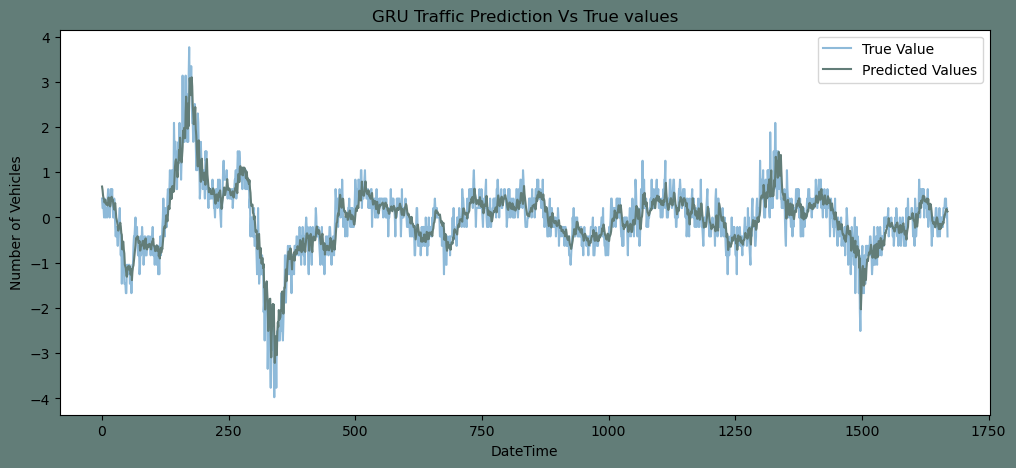

In [26]:
PredJ1 = GRU_model(X_trainJ1, y_trainJ1, X_testJ1)
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
MAE_J1 = MAE_Value(y_testJ1, PredJ1)
PredictionsPlot(y_testJ1, PredJ1, 0)

Epoch 1/50
103/103 [==============================] - 26s 196ms/step - loss: 1.0012
Epoch 2/50
103/103 [==============================] - 22s 217ms/step - loss: 0.8939
Epoch 3/50
103/103 [==============================] - 23s 220ms/step - loss: 0.8679
Epoch 4/50
103/103 [==============================] - 23s 226ms/step - loss: 0.8548
Epoch 5/50
103/103 [==============================] - 24s 230ms/step - loss: 0.8517
Epoch 6/50
103/103 [==============================] - 23s 219ms/step - loss: 0.8389
Epoch 7/50
103/103 [==============================] - 22s 218ms/step - loss: 0.8427
Epoch 8/50
103/103 [==============================] - 22s 218ms/step - loss: 0.8384
Epoch 9/50
103/103 [==============================] - 25s 238ms/step - loss: 0.8330
Epoch 10/50
103/103 [==============================] - 25s 239ms/step - loss: 0.8382
Epoch 11/50
103/103 [==============================] - 24s 229ms/step - loss: 0.8287
Epoch 12/50
103/103 [==============================] - 24s 238ms/step - lo

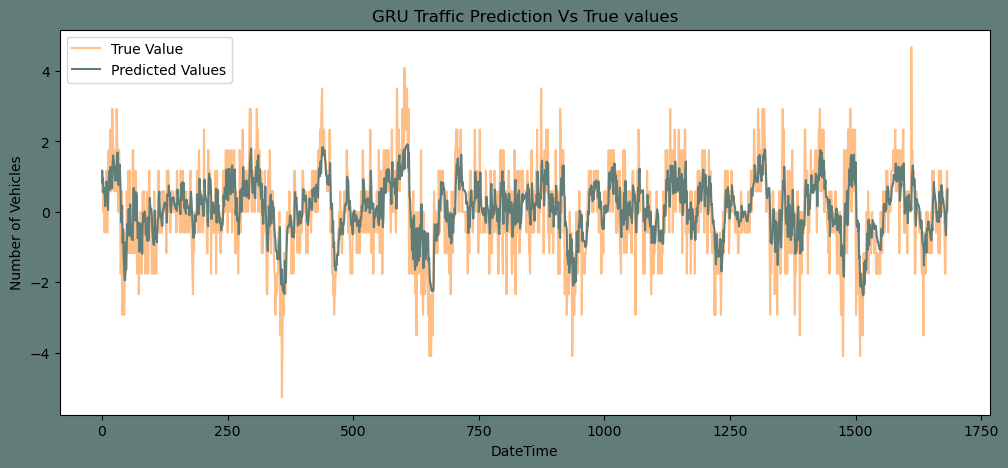

In [27]:
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)
MAE_J2 = MAE_Value(y_testJ2, PredJ2)
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

Epoch 1/50
103/103 [==============================] - 31s 243ms/step - loss: 0.7114
Epoch 2/50
103/103 [==============================] - 26s 251ms/step - loss: 0.6213
Epoch 3/50
103/103 [==============================] - 26s 253ms/step - loss: 0.5916
Epoch 4/50
103/103 [==============================] - 27s 262ms/step - loss: 0.5709
Epoch 5/50
103/103 [==============================] - 25s 246ms/step - loss: 0.5628
Epoch 6/50
103/103 [==============================] - 24s 237ms/step - loss: 0.5562
Epoch 7/50
103/103 [==============================] - 24s 235ms/step - loss: 0.5543
Epoch 8/50
103/103 [==============================] - 25s 246ms/step - loss: 0.5489
Epoch 9/50
103/103 [==============================] - 26s 254ms/step - loss: 0.5493
Epoch 10/50
103/103 [==============================] - 27s 261ms/step - loss: 0.5483
Epoch 11/50
103/103 [==============================] - 26s 253ms/step - loss: 0.5443
Epoch 12/50
103/103 [==============================] - 24s 236ms/step - lo

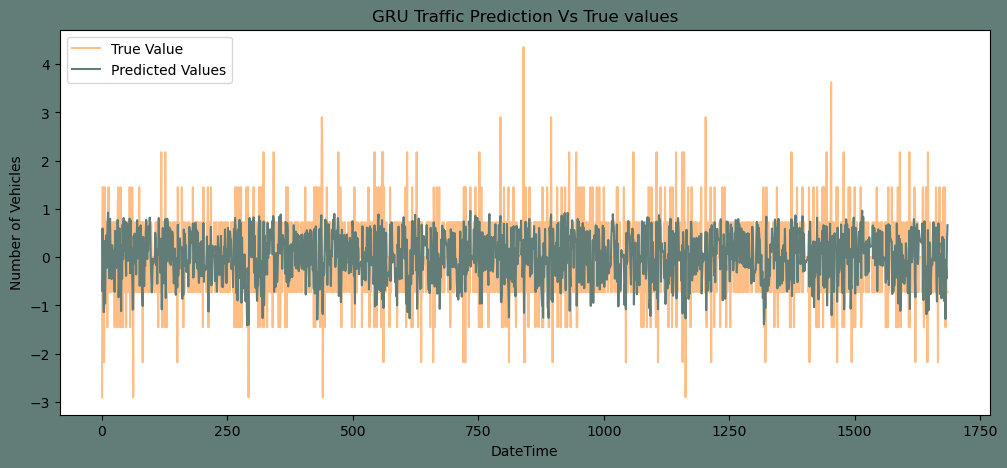

In [28]:
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)
MAE_J3 = MAE_Value(y_testJ3, PredJ3)
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,1)

Epoch 1/50
103/103 [==============================] - 28s 214ms/step - loss: 0.6234
Epoch 2/50
103/103 [==============================] - 22s 215ms/step - loss: 0.5380
Epoch 3/50
103/103 [==============================] - 23s 219ms/step - loss: 0.5151
Epoch 4/50
103/103 [==============================] - 23s 226ms/step - loss: 0.4994
Epoch 5/50
103/103 [==============================] - 22s 215ms/step - loss: 0.4939
Epoch 6/50
103/103 [==============================] - 24s 229ms/step - loss: 0.4870
Epoch 7/50
103/103 [==============================] - 26s 251ms/step - loss: 0.4852
Epoch 8/50
103/103 [==============================] - 23s 229ms/step - loss: 0.4804
Epoch 9/50
103/103 [==============================] - 22s 209ms/step - loss: 0.4802
Epoch 10/50
103/103 [==============================] - 22s 209ms/step - loss: 0.4794
Epoch 11/50
103/103 [==============================] - 24s 229ms/step - loss: 0.4785
Epoch 12/50
103/103 [==============================] - 23s 222ms/step - lo

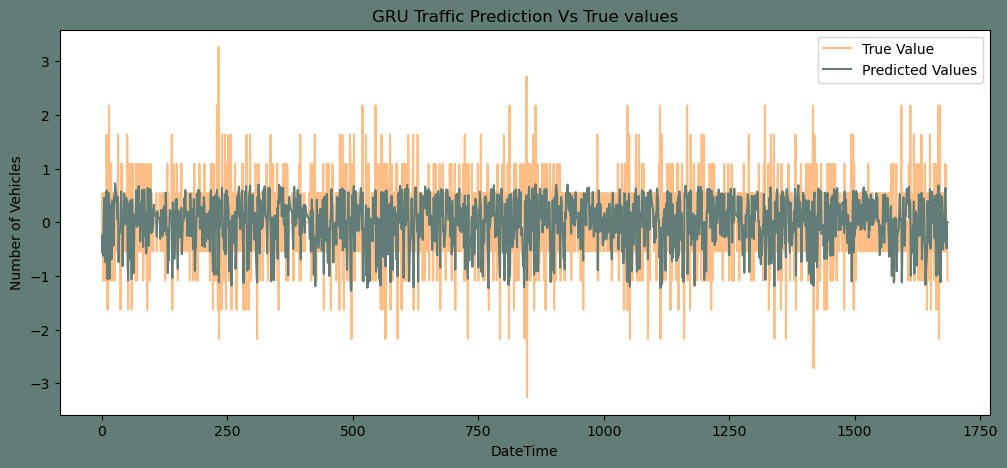

In [29]:
PredJ4 = GRU_model(X_trainJ4, y_trainJ4, X_testJ4)
MAE_J4 = MAE_Value(y_testJ4, PredJ4)
RMSE_J4 = RMSE_Value(y_testJ4, PredJ4)
PredictionsPlot(y_testJ4, PredJ4, 1)

Epoch 1/50
103/103 [==============================] - 30s 236ms/step - loss: 0.4378
Epoch 2/50
103/103 [==============================] - 30s 287ms/step - loss: 0.3645
Epoch 3/50
103/103 [==============================] - 30s 294ms/step - loss: 0.3495
Epoch 4/50
103/103 [==============================] - 32s 312ms/step - loss: 0.3369
Epoch 5/50
103/103 [==============================] - 31s 303ms/step - loss: 0.3301
Epoch 6/50
103/103 [==============================] - 30s 288ms/step - loss: 0.3271
Epoch 7/50
103/103 [==============================] - 31s 298ms/step - loss: 0.3209
Epoch 8/50
103/103 [==============================] - 32s 312ms/step - loss: 0.3187
Epoch 9/50
103/103 [==============================] - 30s 293ms/step - loss: 0.3165
Epoch 10/50
103/103 [==============================] - 33s 323ms/step - loss: 0.3163
Epoch 11/50
103/103 [==============================] - 29s 281ms/step - loss: 0.3141
Epoch 12/50
103/103 [==============================] - 31s 299ms/step - lo

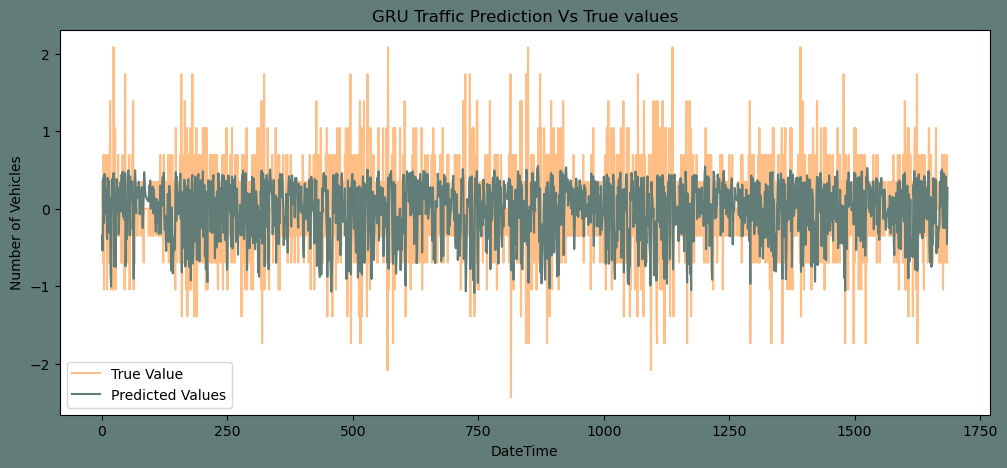

In [30]:
PredJ5 = GRU_model(X_trainJ5, y_trainJ5, X_testJ5)
MAE_J5 = MAE_Value(y_testJ5, PredJ5)
RMSE_J5 = RMSE_Value(y_testJ5, PredJ5)
PredictionsPlot(y_testJ5, PredJ5, 1)

In [ ]:
PredJ6 = GRU_model(X_trainJ6, y_trainJ6, X_testJ6)
MAE_J6 = MAE_Value(y_testJ6, PredJ6)
RMSE_J6 = RMSE_Value(y_testJ6, PredJ6)
PredictionsPlot(y_testJ6, PredJ6, 1)

In [ ]:
PredJ7 = GRU_model(X_trainJ7, y_trainJ7, X_testJ7)
MAE_J7 = MAE_Value(y_testJ7, PredJ7)
RMSE_J7 = RMSE_Value(y_testJ7, PredJ7)
PredictionsPlot(y_testJ7, PredJ7, 1)

In [ ]:
PredJ8 = GRU_model(X_trainJ8, y_trainJ8, X_testJ8)
MAE_J8 = MAE_Value(y_testJ8, PredJ8)
RMSE_J8 = RMSE_Value(y_testJ8, PredJ8)
PredictionsPlot(y_testJ8, PredJ8, 1)

In [31]:
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

In [32]:
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["uenomax"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

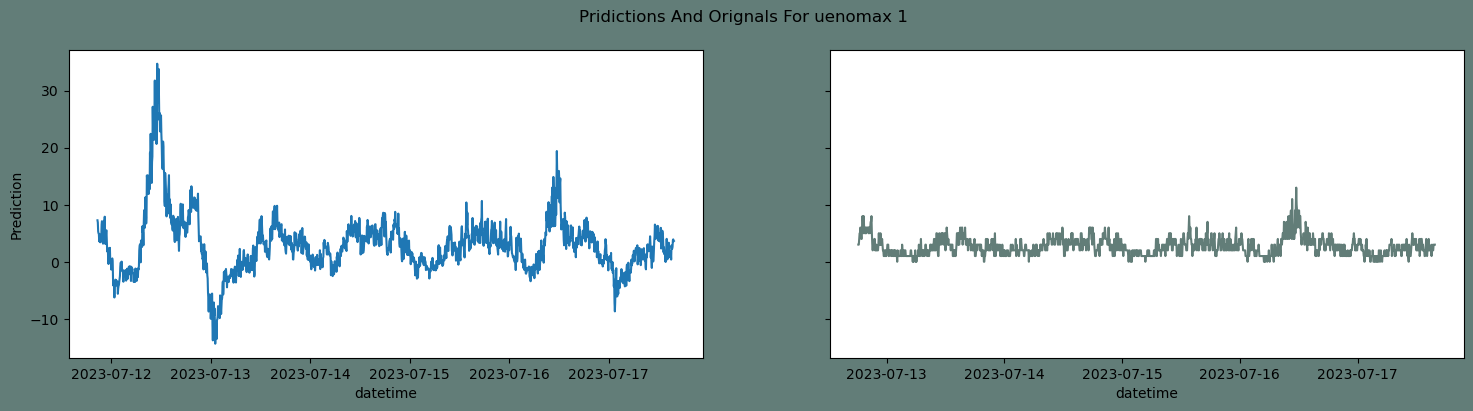

In [33]:
recover1 = df_N1.Norm[-1671:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For uenomax 1", 0)

In [42]:
Transform_reverssed_J1

,Pred_Normed,Pred_Final
datetime,,
2023-07-11 20:40:00,0.744829,7.272720
2023-07-11 20:45:00,0.666597,6.898673
2023-07-11 20:50:00,0.337094,5.323257
2023-07-11 20:55:00,0.269873,5.001856
2023-07-11 21:00:00,0.253657,4.924327
...,...,...
2023-07-17 15:25:00,-0.234157,2.591992
2023-07-17 15:30:00,0.015774,3.786958
2023-07-17 15:35:00,0.044613,3.924844


In [59]:
submission_data_indexed

,BaseStationB,BaseStationJ
datetime,,
2023-07-11 20:40:00,0,0
2023-07-11 20:45:00,0,0
2023-07-11 20:50:00,0,0
2023-07-11 20:55:00,0,0
2023-07-11 21:00:00,0,0
...,...,...
2023-07-17 15:25:00,0,0
2023-07-17 15:30:00,0,0
2023-07-17 15:35:00,0,0


In [54]:
Transform_reversed_J1_indexed

datetime
2023-07-11 20:40:00    7.272720
2023-07-11 20:45:00    6.898673
2023-07-11 20:50:00    5.323257
2023-07-11 20:55:00    5.001856
2023-07-11 21:00:00    4.924327
                         ...   
2023-07-17 15:25:00    2.591992
2023-07-17 15:30:00    3.786958
2023-07-17 15:35:00    3.924844
2023-07-17 15:40:00    3.698370
2023-07-17 15:45:00    3.634982
Name: Pred_Final, Length: 1670, dtype: float64

In [64]:
# submission_data와 Transform_reversed_J5 인덱스를 설정
submission_data_indexed = submission_data[-1671:-1].set_index("datetime")
Transform_reversed_J1_indexed = Transform_reverssed_J1["Pred_Final"]

data = {
    "datetime": submission_data_indexed.index,
    "BaseStationB": Transform_reverssed_J1["Pred_Final"],
    "BaseStationJ": Transform_reverssed_J1["Pred_Final"]
}

new_dataframe = pd.DataFrame(data)

new_dataframe.to_csv('result_0813.csv', index=True)

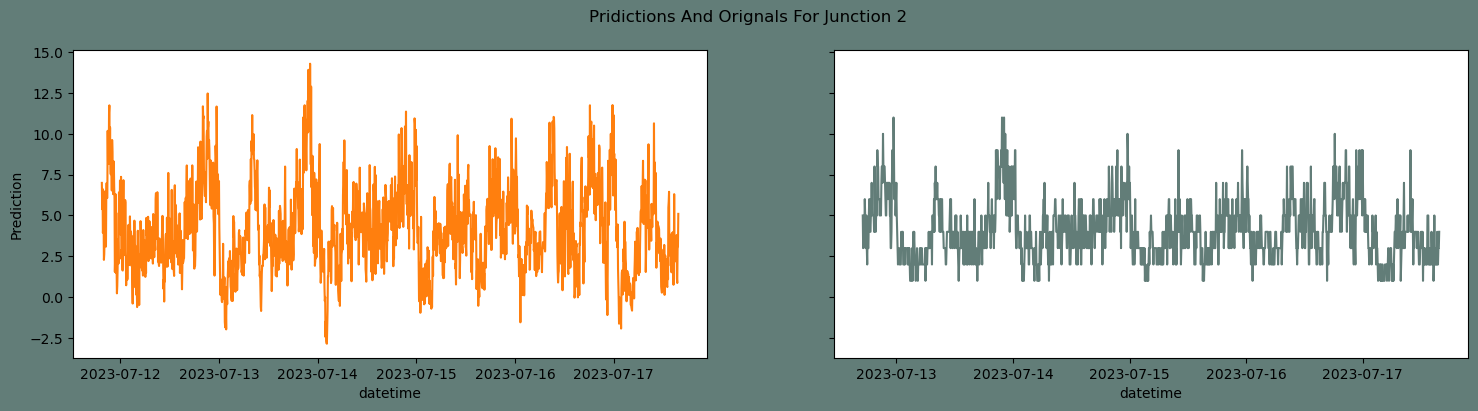

In [34]:
recover2 = df_N2.Norm[-1685:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

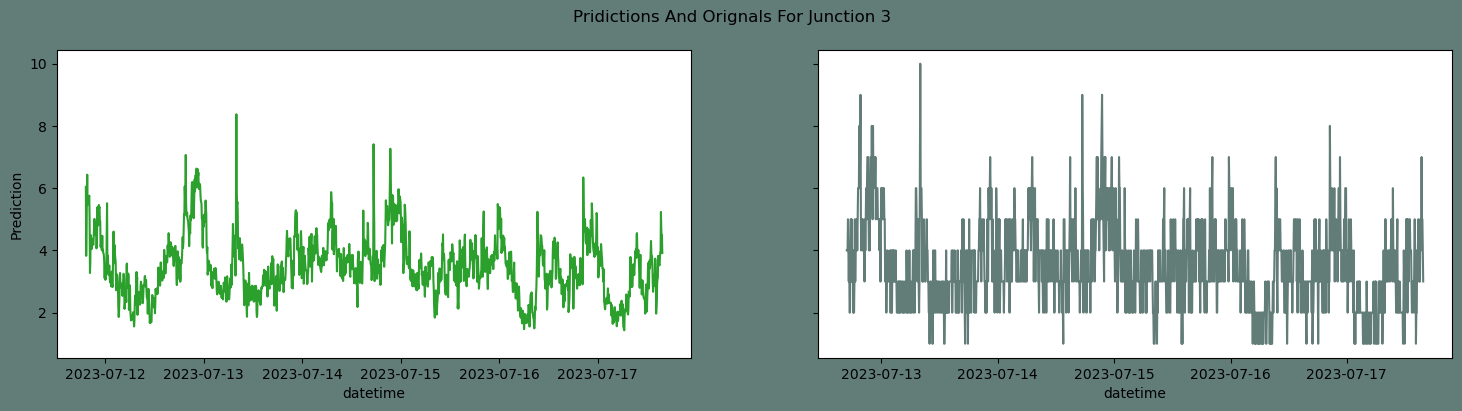

In [35]:
recover3 = df_N3.Norm[-1687:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

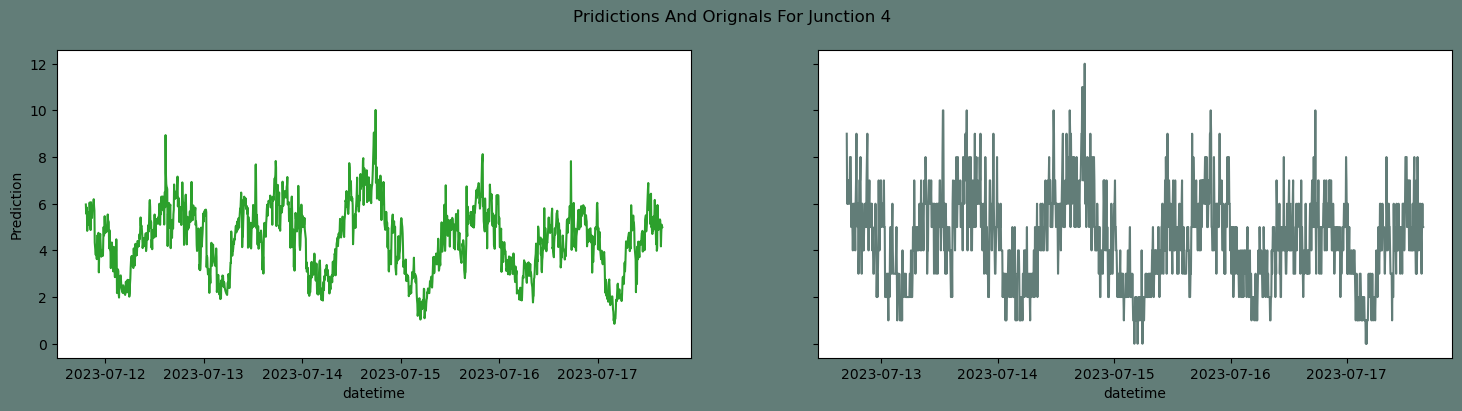

In [36]:
recover4 = df_N4.Norm[-1687:-1].to_frame() #len as per the diff
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-1429:-1],"Pridictions And Orignals For Junction 4", 2)

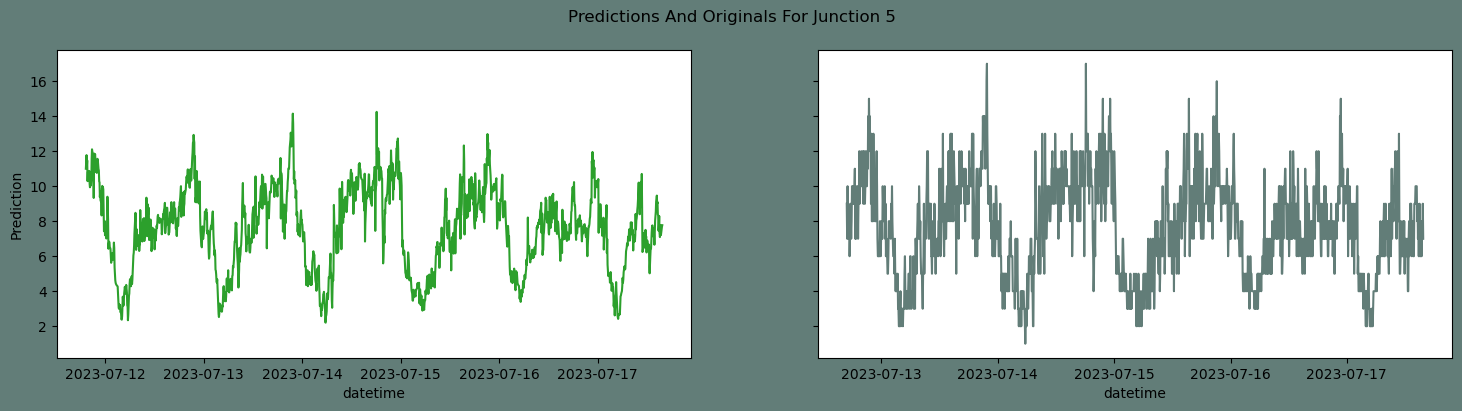

In [37]:
recover5 = df_N5.Norm[-1687:-1].to_frame()
recover5["Pred"] = PredJ5
Transform_reversed_J5 = inverse_difference(recover5.Norm, recover5.Pred).to_frame()
Transform_reversed_J5.columns = ["Pred_Normed"]
Final_J5_Pred = (Transform_reversed_J5.values * std_J5) + av_J5
Transform_reversed_J5["Pred_Final"] = Final_J5_Pred
Sub_Plots2(Transform_reversed_J5["Pred_Final"], df_5[-1429:-1], "Predictions And Originals For Junction 5", 2)


In [40]:
PredJ1

NameError: name 'Pred_J1' is not defined

In [ ]:
recover6 = df_N6.Norm[-1687:-1].to_frame()
recover6["Pred"] = PredJ6
Transform_reversed_J6 = inverse_difference(recover6.Norm, recover6.Pred).to_frame()
Transform_reversed_J6.columns = ["Pred_Normed"]
Final_J6_Pred = (Transform_reversed_J6.values * std_J6) + av_J6
Transform_reversed_J6["Pred_Final"] = Final_J6_Pred
Sub_Plots2(Transform_reversed_J6["Pred_Final"], df_6[-1429:-1], "Predictions And Originals For Junction 6", 2)


In [ ]:
recover7 = df_N7.Norm[-1687:-1].to_frame()
recover7["Pred"] = PredJ7
Transform_reversed_J7 = inverse_difference(recover7.Norm, recover7.Pred).to_frame()
Transform_reversed_J7.columns = ["Pred_Normed"]
Final_J7_Pred = (Transform_reversed_J7.values * std_J7) + av_J7
Transform_reversed_J7["Pred_Final"] = Final_J7_Pred
Sub_Plots2(Transform_reversed_J7["Pred_Final"], df_7[-1429:-1], "Predictions And Originals For Junction 7", 2)


In [ ]:
recover8 = df_N8.Norm[-1687:-1].to_frame()
recover8["Pred"] = PredJ8
Transform_reversed_J8 = inverse_difference(recover8.Norm, recover8.Pred).to_frame()
Transform_reversed_J8.columns = ["Pred_Normed"]
Final_J8_Pred = (Transform_reversed_J8.values * std_J8) + av_J8
Transform_reversed_J8["Pred_Final"] = Final_J8_Pred
Sub_Plots2(Transform_reversed_J8["Pred_Final"], df_8[-1429:-1], "Predictions And Originals For Junction 8", 2)


In [43]:
submission_data = pd.read_csv("./csv_file/Q1_label_sample.csv")

In [ ]:
Transform_reversed_J5 = Transform_reversed_J5.reset_index()

In [ ]:
Final_J5_Pred

In [ ]:
np.exp(Final_J5_Pred)

In [ ]:
Transform_reversed_J5Transform_reversed_J5[['Pred_Final']]

In [ ]:
submission_data["datetime"][-1687:-1]

In [ ]:
Final_J5_Pred

In [ ]:
submission_data_indexed.shape

In [ ]:
import pandas as pd
import numpy as np

# submission_data와 Transform_reversed_J5 인덱스를 설정
submission_data_indexed = submission_data[-1687:-1].set_index("datetime")
Transform_reversed_J5_indexed = Transform_reversed_J5["Pred_Final"]

# 데이터프레임 생성
data = {
    "datetime": submission_data_indexed.index,
    "BaseStationB": np.exp(Transform_reversed_J5_indexed.values),
    "BaseStationJ": np.exp(Transform_reversed_J5_indexed.values)
}

new_dataframe = pd.DataFrame(data)

new_dataframe

In [ ]:
new_dataframe.to_csv('result_2.csv')